### RetinaNet으로 자율주행시스템 만들어보기
---
- mkdir -p ~/aiffel/object_detection/data
   
     
- pip uninstall tensorflow
- pip install tensorflow==2.3.0
   
   
- cd ~/aiffel/object_detection
- git clone https://github.com/fizyr/keras-retinanet.git
- cd keras-retinanet && python setup.py build_ext --inplace  
  
    
      
- pip install tensorflow_datasets tqdm
- pip install -r requirements.txt
- pip install .

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

### 자율주행 보조장치 (1) KITTI 데이터셋
- [KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)
#### 요구사항
 - 사람이 카메라에 감지되면 정지
 - 차량이 일정 크기 이상으로 감지되면 정지

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [ ]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [13]:
import os
ds_train = os.getenv('HOME')+'/tensorflow_datasets/kitti'
ds_test = os.getenv('HOME')+'/tensorflow_datasets/kitti'
ds_info = os.getenv('HOME')+'/tensorflow_datasets/kitti/3.2.0/dataset_info.json' 


In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

In [ ]:
ds_info

### 자율주행 보조장치 (2) 데이터 직접 확인하기

In [ ]:
TakeDataset = ds_train.take(1)

In [ ]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

In [ ]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### RetinaNet
#### focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용하는 Net
#### 참고자료
- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
- [kimcando94님의 Object Detection에 대하여_01: Overall Object detection flow](https://kimcando94.tistory.com/115)
- [김홍배님의 Focal loss의 응용(Detection & Classification)](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)

### keras-retinanet 실습 (1) 데이터 포맷 변경
- [keras-retinanet](https://github.com/fizyr/keras-retinanet)

#### 클래스 및 바운딩 박스 정보 추출

In [ ]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

In [ ]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

#### 클래스 맵핑
  데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야함  
  이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

### keras-retinanet 실습 (2) 셋팅

In [1]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-15 12:11:07.899871: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-15 12:11:09.989416: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-15 12:11:10.017840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-15 12:11:10.018389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-15 12:11:10.018418: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-15 12:11:10.049065: I tensorflow/stream_executor/platform

Epoch 1/50
2021-04-15 12:11:22.502755: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-15 12:11:23.754964: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-15 12:11:23.784624: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-15 12:11:24.045561: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
195/195 [==============================] - ETA: 0s - loss: 3.4923 - regression_loss: 2.6719 - classification_loss: 0.8204
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 59s 304ms/step - loss: 3.4923 - regression_loss: 2.6719 - classification_loss: 0.82

195/195 [==============================] - ETA: 0s - loss: 1.4150 - regression_loss: 1.1023 - classification_loss: 0.3127
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 59s 300ms/step - loss: 1.4150 - regression_loss: 1.1023 - classification_loss: 0.3127
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.3667 - regression_loss: 1.0621 - classification_loss: 0.3046
Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5
195/195 [==============================] - 59s 300ms/step - loss: 1.3667 - regression_loss: 1.0621 - classification_loss: 0.3046
Epoch 18/50
195/195 [==============================] - ETA: 0s - loss: 1.4472 - regression_loss: 1.1023 - classification_loss: 0.3448
Epoch 00018: saving model to ./snapshots/resnet50_csv_18.h5
195/195 [==============================] - 58s 300ms/step - loss: 1.4472 - regression_loss: 1.1023 - classification_loss: 0.3448
Epoch 19/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 0.9871 - regression_loss: 0.7406 - classification_loss: 0.2465
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 58s 300ms/step - loss: 0.9871 - regression_loss: 0.7406 - classification_loss: 0.2465
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 1.0177 - regression_loss: 0.7706 - classification_loss: 0.2471
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
195/195 [==============================] - 59s 300ms/step - loss: 1.0177 - regression_loss: 0.7706 - classification_loss: 0.2471
Epoch 34/50
195/195 [==============================] - ETA: 0s - loss: 0.9729 - regression_loss: 0.7488 - classification_loss: 0.2241
Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
195/195 [==============================] - 58s 300ms/step - loss: 0.9729 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.0172 - regression_loss: 0.7699 - classification_loss: 0.2473
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5
195/195 [==============================] - 58s 299ms/step - loss: 1.0172 - regression_loss: 0.7699 - classification_loss: 0.2473
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 0.9978 - regression_loss: 0.7601 - classification_loss: 0.2377
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
195/195 [==============================] - 58s 299ms/step - loss: 0.9978 - regression_loss: 0.7601 - classification_loss: 0.2377
Epoch 50/50
195/195 [==============================] - ETA: 0s - loss: 1.0332 - regression_loss: 0.7871 - classification_loss: 0.2460
Epoch 00050: saving model to ./snapshots/resnet50_csv_50.h5
195/195 [==============================] - 58s 300ms/step - loss: 1.0332 - regression_loss:

In [2]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-15 13:56:45.223588: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-15 13:56:47.069558: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-15 13:56:47.083273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-15 13:56:47.083698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-15 13:56:47.083720: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-15 13:56:47.087655: I tensorflow/stream_executor/platform

### keras-retinanet 실습 (3) 시각화
- mkdir -p ~/aiffel/object_detection/test_set
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
- mv test_set.zip ~/aiffel/object_detection/test_set
- cd ~/aiffel/object_detection/test_set && unzip test_set.zip

In [3]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

1 Physical GPUs, 1 Logical GPUs


[593.2534  175.36464 626.6414  206.97163]
[194.5057  135.7769  364.8199  230.25156]


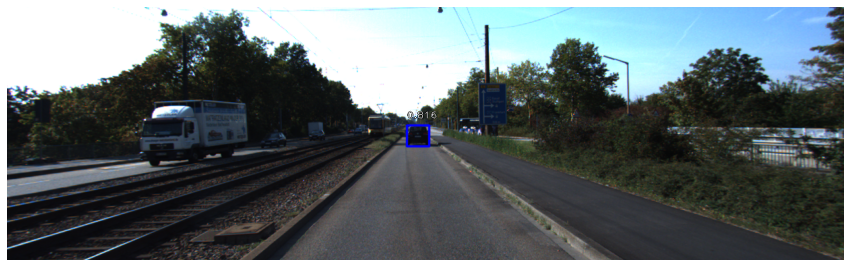

In [4]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[771.47614 151.46973 840.835   315.93738]
[771.71265 154.00262 843.78503 315.3626 ]


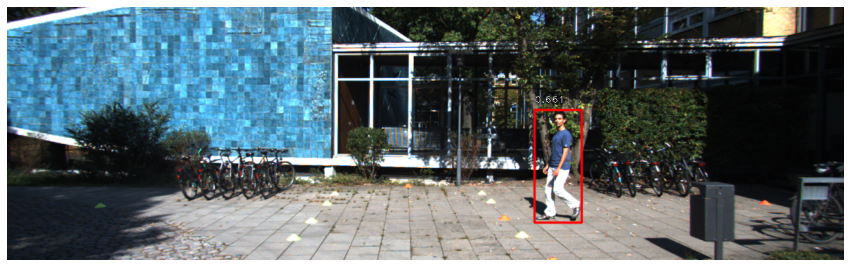

In [5]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

### 프로젝트: 자율주행 보조 시스템 만들기

#### 1. 자율주행 시스템 만들기

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
  - 사람이 한 명 이상 있는 경우
  - 차량의 크기(width or height)가 300px이상인 경우

In [6]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    result = "Go"
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0,0,255),
        1:(255,0,0)
    }
    
    # 이미지 전처리
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # peocess image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)
            
            if b[1]-b[0] >= 300 or b[2]-b[0] >= 300 or label == 1 :
                result = 'Stop'
            else:
                result = 'Go'

            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=20)
        plt.imshow(draw)
        plt.show()
    
        return result

In [7]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

/home/ssac24/aiffel/object_detection/test_set/stop_1.png
[771.47614 151.46973 840.835   315.93738]
[771.71265 154.00262 843.78503 315.3626 ]


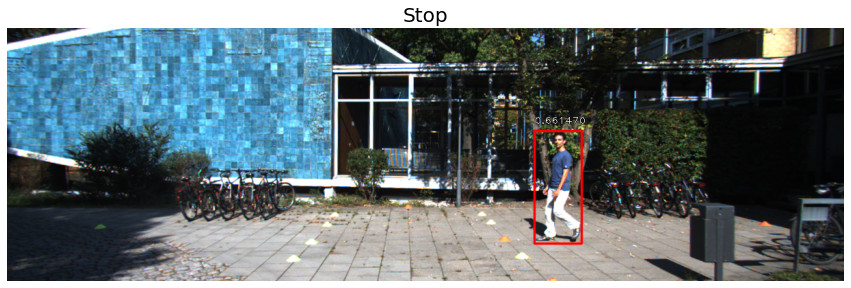

/home/ssac24/aiffel/object_detection/test_set/stop_2.png
[412.31656 165.82458 498.9753  330.58585]
[408.37836 172.04689 501.47952 331.24182]


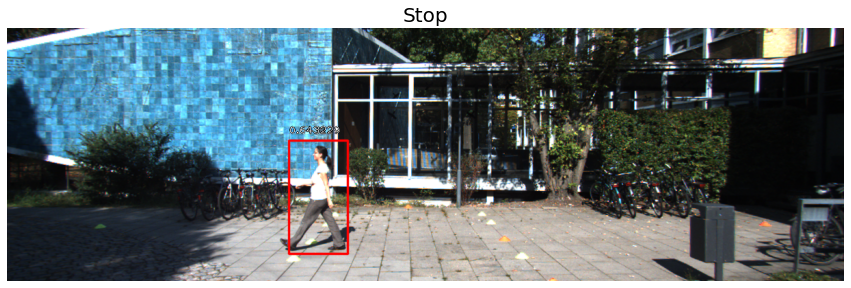

/home/ssac24/aiffel/object_detection/test_set/stop_3.png
[  0.8554074 202.63025   295.43127   369.12827  ]
[750.46924 161.14804 889.3786  210.33806]


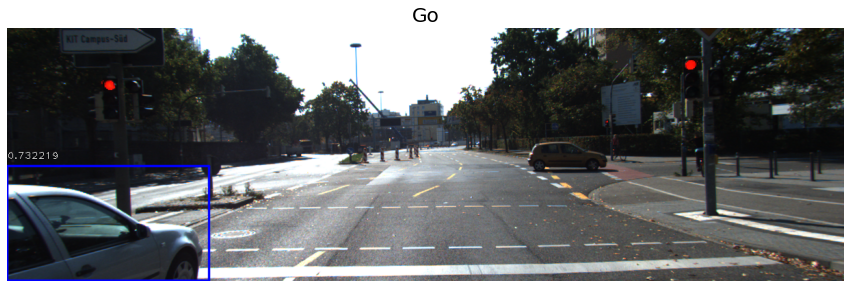

/home/ssac24/aiffel/object_detection/test_set/stop_4.png
[ 731.1647     44.298225 1102.7699    353.6788  ]
[ 42.959232 158.35536  371.27213  310.301   ]


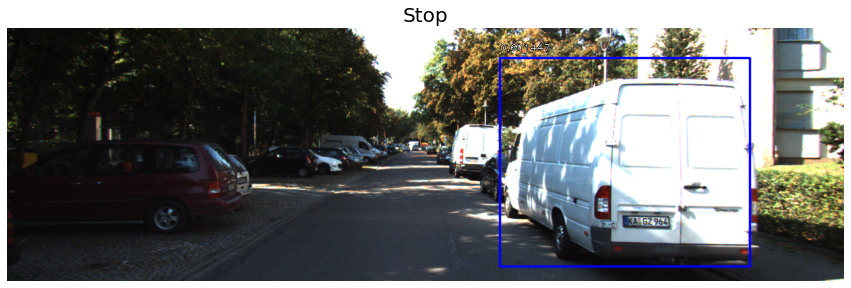

/home/ssac24/aiffel/object_detection/test_set/stop_5.png
[ 873.46704  165.7943  1238.7339   369.15372]
[565.7801  181.39258 613.1343  217.48672]


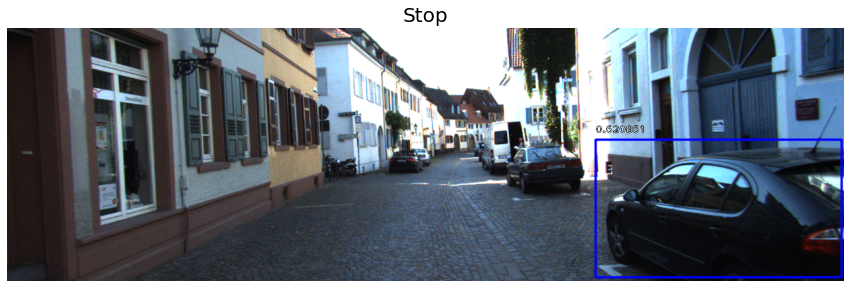

/home/ssac24/aiffel/object_detection/test_set/go_1.png
[593.2534  175.36464 626.6414  206.97163]
[194.5057  135.7769  364.8199  230.25156]


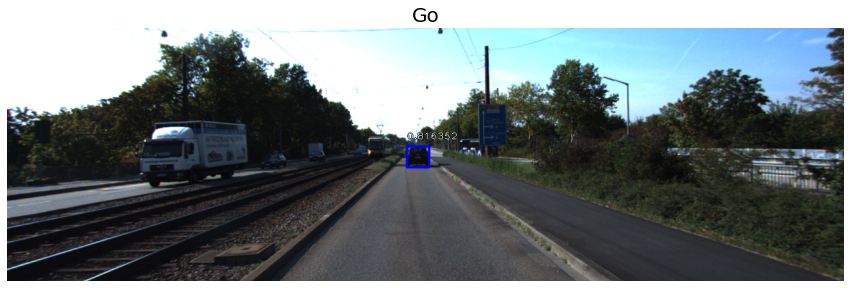

/home/ssac24/aiffel/object_detection/test_set/go_2.png
[626.77124 176.33795 666.72943 214.05537]
[515.57153 175.50978 567.87256 214.47952]


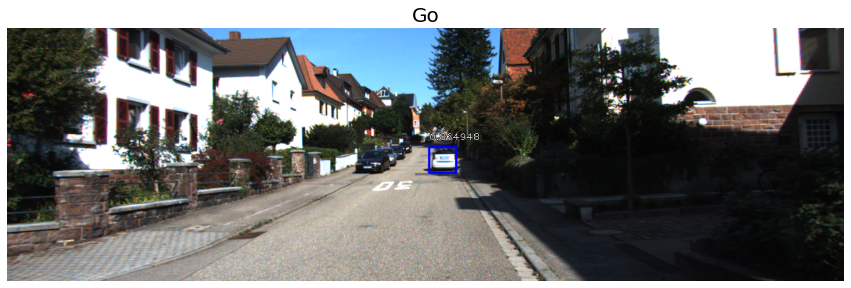

/home/ssac24/aiffel/object_detection/test_set/go_3.png
[812.381   146.45207 887.3735  185.03317]


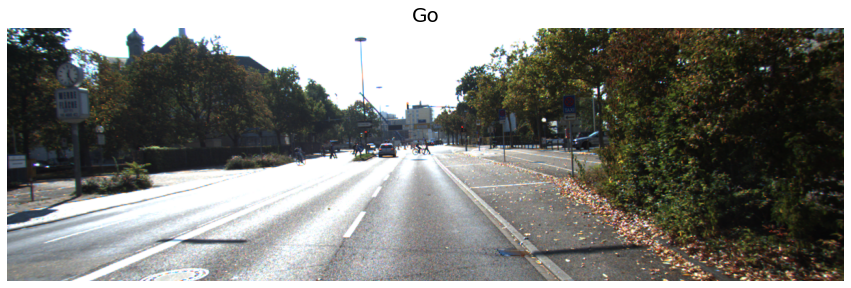

/home/ssac24/aiffel/object_detection/test_set/go_4.png
[698.5051  170.14894 785.28613 252.37918]
[654.992   176.65498 799.65015 263.7804 ]


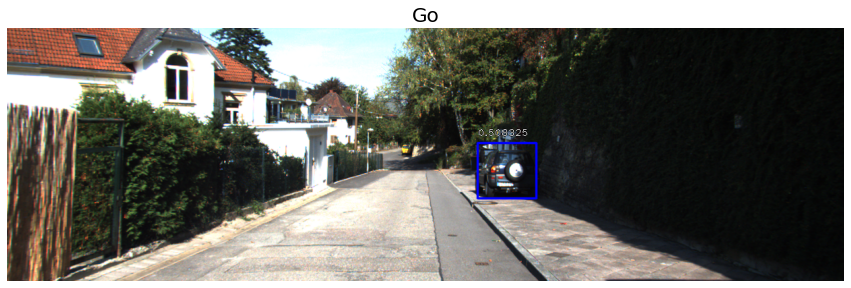

/home/ssac24/aiffel/object_detection/test_set/go_5.png
[  6.996946 189.71516  211.18898  310.10654 ]


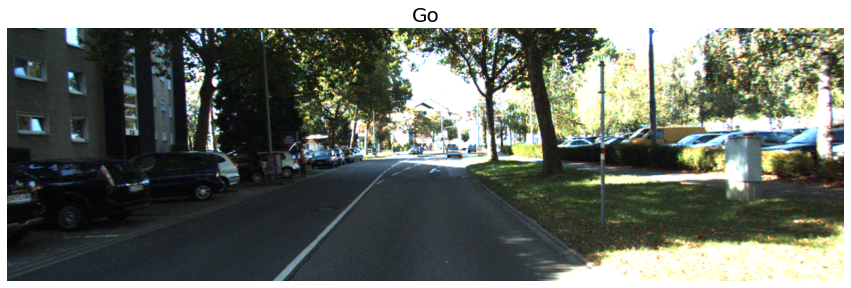

90점입니다.


In [8]:
test_system(self_drive_assist)